In [136]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx

import pandas as pd
import os
import galois

To do:
* need to fix either the Manhattan or the tanner graph function (cluster not symmetric)

In [137]:
Lx, Ly = [10,10]
GF = galois.GF(3)

In [138]:
def tuple_sum(p:Tuple[complex], e:Tuple[complex], Lx, Ly):
    x = (p.real + e.real) % (2*Lx)
    y = (p.imag + e.imag) % (2*Ly)

    return (x+1j*y)

In [139]:
class TC3():
    def __init__(self, Lx, Ly):
        self.Lx, self.Ly = [Lx,Ly]

    def check_data_lists(self):
        qudits_from_plaq: List[Tuple[complex]] = [(1+0*1j), (0+1j)]
        plaq_centers: List[Tuple[complex,complex]] = [((2*i) % (2*self.Lx) + ((2*k) % (2*self.Ly))*1j) for i in range(self.Lx) for k in range(self.Ly)]

        qudits_list: List[Tuple[complex]] = []
        for plaq in plaq_centers:
            qudits_list.append(tuple_sum(plaq, qudits_from_plaq[0], self.Lx, self.Ly))
            qudits_list.append(tuple_sum(plaq, qudits_from_plaq[1], self.Lx, self.Ly))

        plaq_qudit_dictionary = {}
        for count, plaq in enumerate(plaq_centers):
            plaq_qudit_dictionary[count] = [tuple_sum(plaq, qudits_from_plaq[0],self.Lx, self.Ly), tuple_sum(plaq, qudits_from_plaq[1],self.Lx, self.Ly),tuple_sum(plaq, -qudits_from_plaq[0],self.Lx, self.Ly), tuple_sum(plaq, -qudits_from_plaq[1],self.Lx, self.Ly) ]


        self.plaq_pos = plaq_centers
        self.qutrit_pos = qudits_list
        self.plaq_vs_qutrits = plaq_qudit_dictionary

    def parity_check(self):
        H = np.zeros((len(self.plaq_pos),len(self.qutrit_pos)), dtype=int)

        for count_p, p in enumerate(self.plaq_pos):
            for count_q, q in enumerate(self.qutrit_pos):
                if q == self.plaq_vs_qutrits[count_p][0]:
                    H[count_p,count_q] = 1
                elif q == self.plaq_vs_qutrits[count_p][1]:
                    H[count_p,count_q] = 1
                elif q == self.plaq_vs_qutrits[count_p][2]:
                    H[count_p,count_q] = 2
                elif q == self.plaq_vs_qutrits[count_p][3]:
                    H[count_p,count_q] = 2
        
        self.H = GF(H)

    def tanner_graph(self):
        "Create tanner graph from a parity check matrix H."
        m, n = self.H.shape
        T = nx.Graph()

        T.H = self.H
        # nodes
        T.VD = [i for i in range(n)]
        T.Dpos = [self.qutrit_pos[i] for i in range(n)]
        T.VC = [-j-1 for j in range(m)]
        T.Cpos = [self.plaq_pos[j] for j in range(m)]

        # add them, with positions
        #for i, node in enumerate(T.VD):
            #T.add_node(node, pos=((i-n/2), 0), label='$d_{'+str(i)+'}$')
        #for j, node in enumerate(T.VC):
            #T.add_node(node, pos=((j-m/2), 1), label='$c_{'+str(j)+'}$')

             #add them, with positions
        for i, node in enumerate(T.VD):
            T.add_node(node, pos=(T.Dpos[i].real, T.Dpos[i].imag), label='$d_{'+str(i)+'}$')
        for j, node in enumerate(T.VC):
            T.add_node(node, pos=(T.Cpos[j].real, T.Cpos[j].imag), label='$c_{'+str(j)+'}$')

        # add checks to graph
        for j, check in enumerate(T.H):
            for i, v in enumerate(check):
                if v==1:
                    T.add_edge(-j-1, i, label = 'Z')
                elif v==2:
                    T.add_edge(-j-1, i, label = 'Zt')

        self.T = T

    def logicals(self):
        qudits = self.T.VD
        Z_vertical, Z_horizontal = [np.zeros(len(qudits), dtype=int), np.zeros(len(qudits), dtype = int)]
        Z_vlist, Z_hlist = [set(), set()]

        for y in range(self.Ly):
            Z_vertical[1+2*y] = 1
            Z_vlist.add(1+2*y)

        for x in range(self.Lx):
            Z_horizontal[1+2*self.Ly*x] = 1
            Z_hlist.add(1+2*self.Ly*x)


        self.Z1, self.Z1list = [Z_vertical, Z_vlist]
        self.Z2, self.Z2list = [Z_horizontal, Z_hlist]

    
        


In [140]:
def draw_tanner_graph(T, highlight_vertices=None):
    "Draw the graph. highlight_vertices is a list of vertices to be colored."
    plt.figure(figsize=(20,15))
    
    pl=nx.get_node_attributes(T,'pos')
    lbls_nodes = nx.get_node_attributes(T, 'label')
    lbls_edges = nx.get_edge_attributes(T, 'label')

    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VD, node_shape='o')
    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VC, node_shape='s')
    nx.draw_networkx_labels(T, pos=pl, labels=lbls_nodes)

    #for i, edge in enumerate(T.edges):
        #nx.draw_networkx_edges(T, pos=pl, edgelist=T.edges[edge])
    
    nx.draw_networkx_edges(T, pos=pl, label= lbls_edges)

    if highlight_vertices:
        nx.draw_networkx_nodes(T,
                               pos=pl,
                               nodelist=[int(v[1:]) for v in highlight_vertices if v[0] == 'd'],
                               node_color='red',
                               node_shape='o')
        nx.draw_networkx_nodes(T,
                       pos=pl,
                       nodelist=[-int(v[1:])-1 for v in highlight_vertices if v[0] == 'c'],
                       node_color='red',
                       node_shape='s')

    
    plt.axis('off');


# these four functions allow us to convert between 
# (s)tring names of vertices and (i)nteger names of vertices
def s2i(node):
    return int(node[1:]) if node[0] == 'd' else -int(node[1])-1

def i2s(node):
    return f'd{node}' if node>=0 else f'c{-node-1}'

def ms2i(W: set):
    return set(map(s2i, W))

def mi2s(W: set):
    return set(map(i2s, W))

def i2pos(T,node):
    return T.Dpos[node] if node>=0 else T.Cpos[-node-1]

In [141]:
C1 = TC3(Lx,Ly)
C1.check_data_lists()
C1.parity_check()
C1.tanner_graph()
C1.logicals()

## Parity check matrix

# Generate Error:

In [142]:
def Error(p, H):
    data_qutrit = np.zeros(H.shape[1], dtype=int)
    for q in range(H.shape[1]):
        p0 = np.random.random(1)
        if p0<p:
            data_qutrit[q] = 1
        elif p<p0<2*p:
            data_qutrit[q] = 2

    return GF(data_qutrit)

def syndrome(E, code):
    return code.T.H @ E
    

def Bad_syndromes(E, code):
    S = syndrome(E, code)
    S_list = [] # want this in terms of node convention above where check nodes labelled by n<0
    for i in range(len(S)):
        if S[i]!=0:
            S_list.append(-i-1)
    
    return S_list

    
    

# Clustering algorithm

In [143]:
# want to write everything in terms of node labels

def Manhattan(nodeC, nodeD, code): #S and T have format [(x+iy, t), syndrome]
    Lx, Ly = [code.Lx, code.Ly]
    pC, pD = [i2pos(code.T, nodeC), i2pos(code.T,nodeD)]
    
    lattice_correction = 0
    if nodeC>-1 and nodeD>-1 and nodeC!=nodeD:
        if nodeC%2==0 and nodeD%2 ==0 and np.real(pC) == np.real(pD):
            lattice_correction +=2
        if nodeC%2==1 and nodeD%2 ==1 and np.imag(pC) == np.imag(pD):
            lattice_correction +=2

    x = min(np.real(pC - pD)%(2*Lx), np.real(-pC + pD)%(2*Lx))
    y = min(np.imag(pC - pD)%(2*Ly), np.imag(-pC + pD)%(2*Ly))
    
    
    
    return x+ y + lattice_correction


def plaquette_nhoods(Error, delta, code, string = False):
    Sbad = Bad_syndromes(Error, code)

    data_nodes = code.T.VD
    check_nodes = code.T.VC
    nodes = list(set(data_nodes).union(set(check_nodes)))
    cluster_list = []

    if string == False:
        for p_bad in Sbad:
            cluster_p = [set([p_bad]), set([])]
            for i,node in enumerate(nodes):
                if Manhattan(p_bad, node, code) < delta:
                    cluster_p[1].add(node)
            cluster_list.append(cluster_p)

    elif string == True:
        for p_bad in Sbad:
            cluster_p = [set([i2s(p_bad)]), set()]
            for i,node in enumerate(nodes):
                if Manhattan(p_bad, node, code) < delta:
                    cluster_p[1].add(i2s(node))
            cluster_list.append(cluster_p)

    return cluster_list
    
# returns a list of clusters [{S1,S2,S3,...}, {nodesD,nodesC}]
# add function to trim interior
def merge_clusters(Error, delta, code):
    balls_list = plaquette_nhoods(Error, delta, code, string = False)
    
    cluster_list = []
    test_ticker = 0
    while(len(balls_list))>0:
        to_delete = [0]
        temp_cluster = balls_list[0] #ball_list[0] = [{plaq}, {qutrits}] 
        for b, ball in enumerate(balls_list[1:]):
            
            if ball[1].isdisjoint(temp_cluster[1]) == False:
                temp_cluster[0] = temp_cluster[0].union(ball[0])
                temp_cluster[1] = temp_cluster[1].union(ball[1])

                to_delete.append(b+1)
                
        for i in reversed(to_delete):
            balls_list.pop(i)
            
        cluster_list.append(temp_cluster)

    return cluster_list

def trim_cluster():

    return
    
    

In [144]:
e = Error(.05,C1.T.H)

In [145]:
len(merge_clusters(e, 2.1, C1))

7

In [146]:
[Manhattan(-3,45,C1), i2pos(C1.T,5), i2pos(C1.T,45)]

[5.0, 5j, (4+5j)]

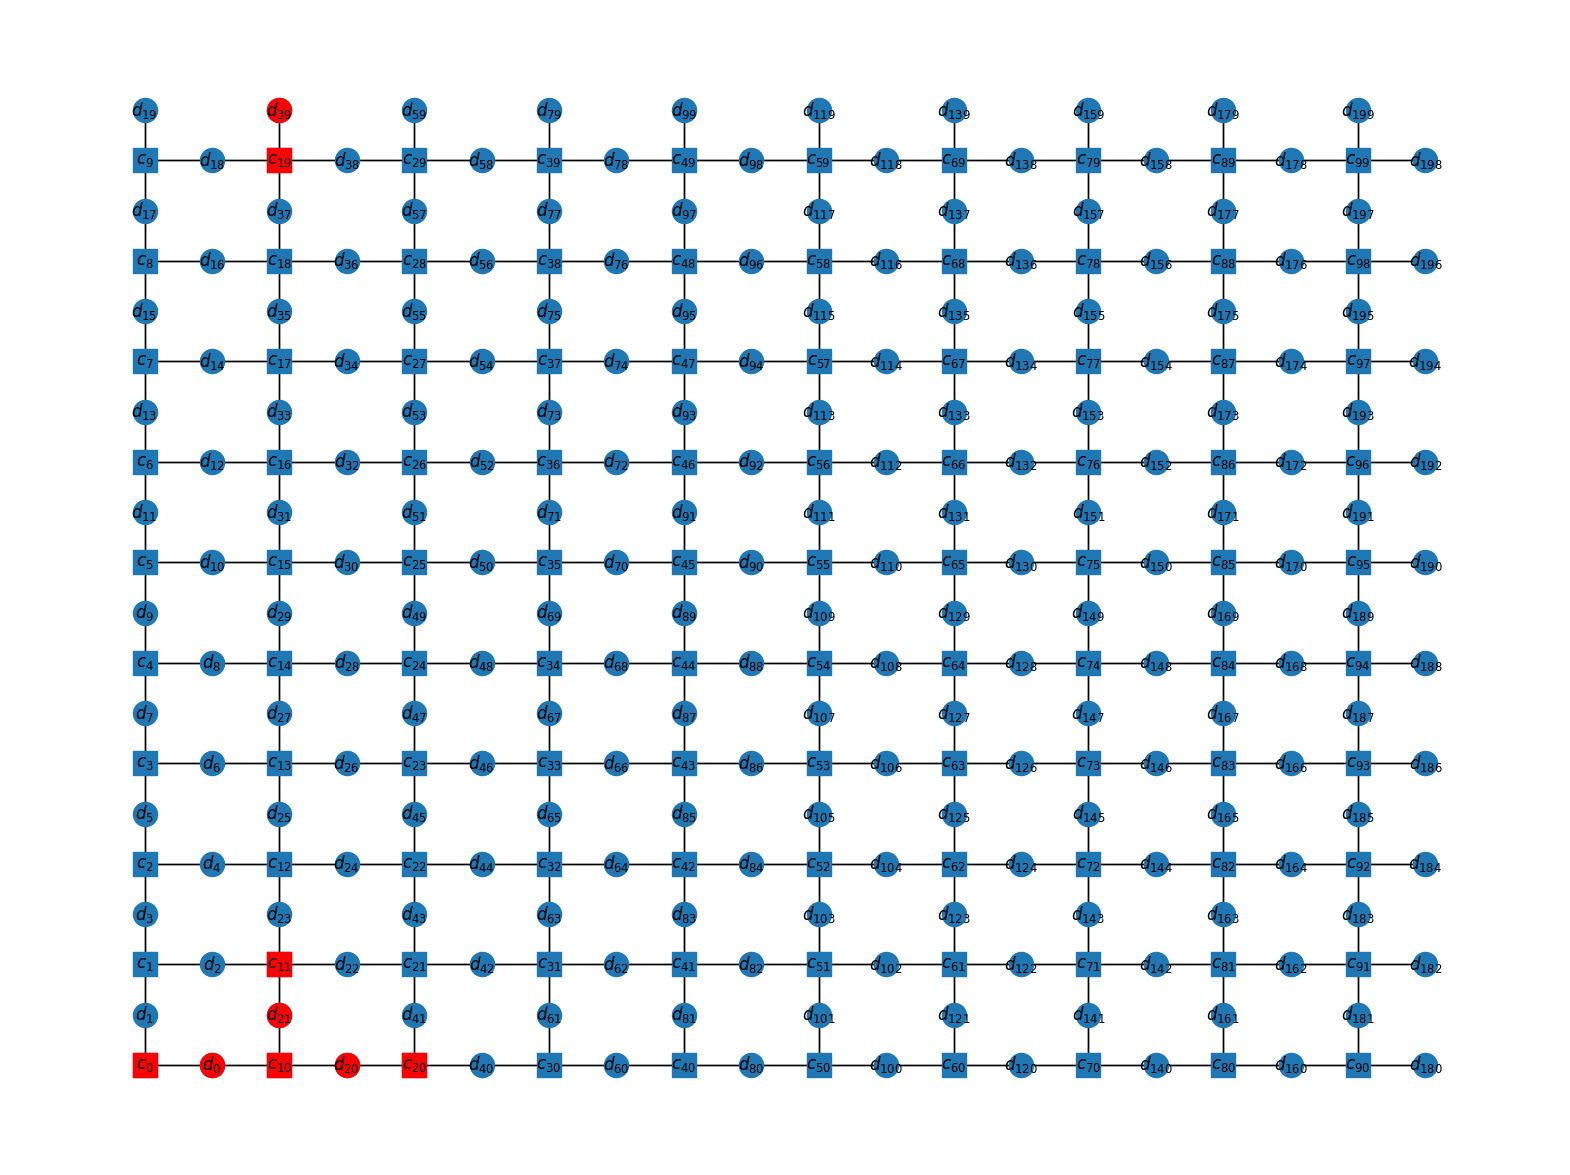

In [147]:
draw_tanner_graph(C1.T,mi2s(merge_clusters(e, 2.1, C1)[1][1]))

## Decoding a cluster:
Suppose we have cluster associated with violated syndromes $S$ and nearby data qubits $e$. These define a submatrix $A$ of the parity check matrix H

Decoding, by guessing an error $\tilde{e}$, amounts to solving the equation: $A \tilde{e} = \sigma(e)_{int(K)}$


$$ He = S \implies \begin{pmatrix}
h_{11} & h_{12} & h_{13} & \dots & S_1\\
h_{21} & h_{22} & h_{23} & \dots & S_2\\
& & \vdots & \\
h_{n1} & h_{n2} & h_{n3} & \dots & S_n\\
 
\end{pmatrix} 
\begin{pmatrix}
e_1 \\ e_2 \\ \vdots \\ e_m \\ -1
\end{pmatrix}

= 0
 

## Start from here: Need to fix this so everything is in terms of Errors

In [148]:
def solvable(H, S):

    H_rank = np.linalg.matrix_rank(H)
    HS = np.hstack((H, np.atleast_2d(S).T))
    
    return H_rank == np.linalg.matrix_rank(HS)

def charged(S):
    is_charged = False
    if S.sum()%3 != 0:
        is_charged == True
    return is_charged


def neutralize(Syndrome):
    S = Syndrome
    charge = S.sum()

    if charge != 0:
        for i, si in enumerate(S):
            for j, sj in enumerate(S):
                if si + sj == charge:
                    S[i] = 0
                    S[j] = 0
                    charge = S.sum()
                    break
    return S



    
def solve_cluster(H,S):
    #find random solution to He = S
    n_data = H.shape[1]
    H_rank = np.linalg.matrix_rank(H)

    
    HS = np.hstack((H, np.atleast_2d(S).T))
    if solvable(H,S) == False:
        raise Exception('something wrong, no solution')
    
    HSrr = HS.row_reduce()

    #swaps 
    swaps = []
    for i in range(min(HSrr.shape)):
        if HSrr[i,i] == 0:
            for j in range(i+1,n_data):
                if HSrr[i,j] != 0:
                    HSrr[:, [i,j]] = HSrr[:, [j,i]]
                    swaps.append((i,j))
                    break

    n_ind = n_data-H_rank
    ind_vars = H.Random(n_ind)

    dep_vars = -HSrr[:H_rank, H_rank:n_data] @ ind_vars + HSrr[:H_rank, -1]

    e = np.hstack((dep_vars, ind_vars))

    for s in reversed(swaps):
        e[s[0]], e[s[1]] = e[s[1]], e[s[0]]


    return GF(e)

Now that we've worked out how to find errors we need to define a function which:
1. Decodes an a given cluster and embeds the solution in the entire space of data qubits
2. does the above for all the clusters, returns the net error and uses this to update the syndrome
3. 

In [187]:
def decode_cluster(Syndrome, cluster, code, Neutralize = True):
    cluster_nodes = cluster[1]
    
    check_nodes = sorted([-node-1 for node in cluster_nodes if node<0])
    data_nodes = sorted([node for node in cluster_nodes if node>=0]) 

    H_sub = code.H[check_nodes][:,data_nodes]
    S_sub = Syndrome[check_nodes]

    full_error = GF(np.zeros(2*code.Lx*code.Ly, dtype=int)) #need to embedd the solution in an array for all the data qubits
    
    if Neutralize:
        solution = solve_cluster(H_sub, neutralize(S_sub))
        for i, node in enumerate(data_nodes):
            full_error[node] = solution[i]
    else:
        if solvable(H_sub, S_sub):
            solution = solve_cluster(H_sub, S_sub) #this will return an correction vector lying in the cluster
        
            for i, node in enumerate(data_nodes):
                full_error[node] = solution[i]


    return GF(full_error)

def decode_cluster_layer(Syndrome, clusters,code, Neutralize = True):
    n_clusters = len(clusters)

    correction = GF(np.zeros(2*code.Lx*code.Ly,dtype=int))
    
    if Neutralize:
        for i, cluster in enumerate(clusters):
            correction += decode_cluster(Syndrome, cluster, code)
    else: 
        for i, cluster in enumerate(clusters):
            correction += decode_cluster(Syndrome, cluster, code, False)

    return correction



def cluster_decoder(Error, code, Neutralize = True):
    E = Error
    S = syndrome(E,code)
    S_index = Bad_syndromes(E,code)

    #print(S)
    E_correction = GF(np.zeros(2*code.Lx*code.Ly,dtype=int))

    for delta in range(2,max(code.Lx,code.Ly),2): # change this
        cluster_list = merge_clusters(E, delta+.1, code)

        E_correction = decode_cluster_layer(S, cluster_list, code, Neutralize)
        E-=E_correction

        S = syndrome(E,code)
        S_index = Bad_syndromes(E,code)
        #print(f"did layer {delta}")


        if len(S_index) == 0:
            break

    return E-Error

In [208]:
e = Error(.04,C1.T.H)
S = syndrome(e, C1)
S_list = Bad_syndromes(e,C1)
clusters = merge_clusters(e, 3.1, C1)

e_corr_n = decode_cluster_layer(S, clusters, C1)
e_corr = decode_cluster_layer(S, clusters, C1, Neutralize=False)

In [209]:
cluster_decoder(e,C1,Neutralize=True)

GF([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], order=3)

In [135]:
neutralize(S)-S

GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

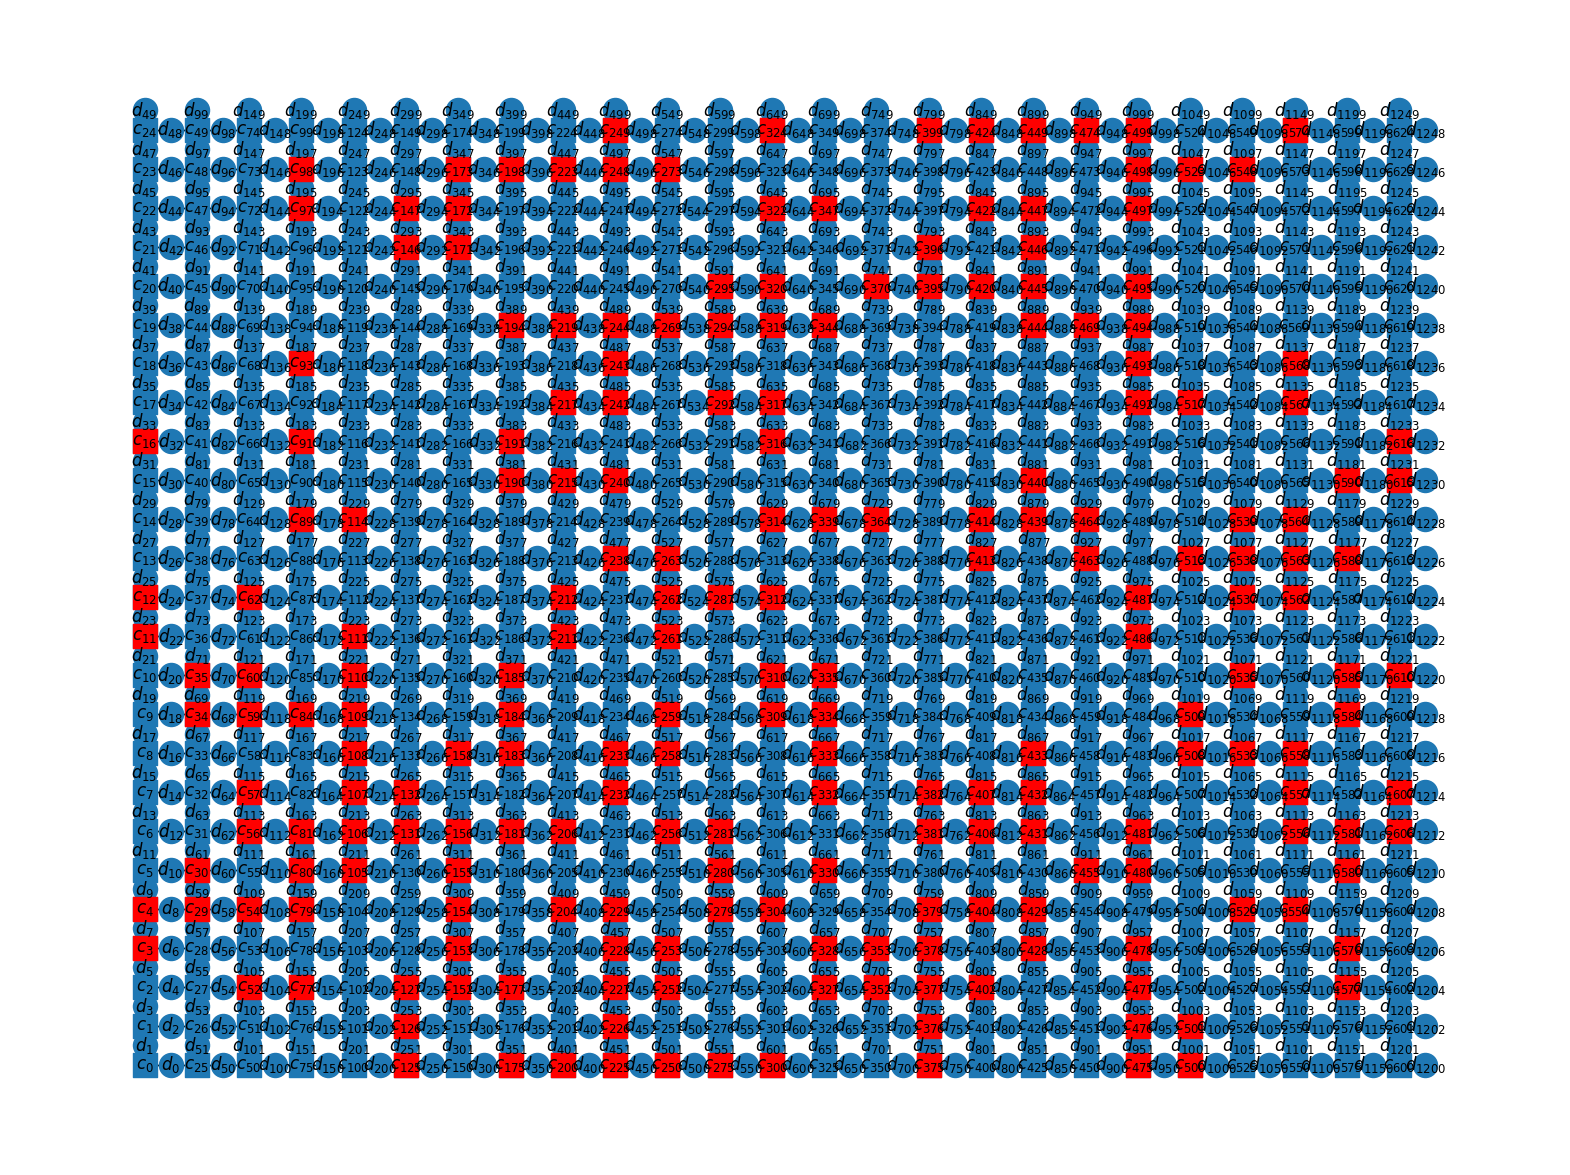

In [36]:
draw_tanner_graph(C1.T, mi2s(S_list))

In [191]:
import time
t0 = time.time()

codeL = TC3(12,12)
codeL.check_data_lists()
codeL.parity_check()
codeL.tanner_graph()
codeL.logicals()


runs = 5*10**2
p=.01
success = 0
convergence_vec = []

for n in range(runs):
    e = Error(p,codeL.T.H)
    e_corr = cluster_decoder(e,codeL)

    if (e_corr)@ GF(codeL.Z1) ==0 and (e_corr)@ GF(codeL.Z2) ==0:
        success+=1
    
    convergence_vec.append(1-success/(n+1))

    if n % int(runs/20) == 0 :
        print(f'runs {n} just finished at time {(time.time()- t0)} and current threshold is {1-success/(n+1)}')

print(f'at onsite error probab of {p} failure occurs {1-success/runs} percent at the time')

runs 0 just finished at time 0.5084640979766846 and current threshold is 0.0


Exception: something wrong, no solution

In [85]:
np.random.random(1)

array([0.84957544])

In [111]:
threshhold_dict = {}
N_list = [15, 25, 35]
p_list = [.0002, .0004, .0006, .0008, .001]

for L in N_list:
    threshhold_dict[L] = []

In [112]:
import time

t0 = time.time()


runs = 10**4
for L in N_list:

    codeL = TC3(L,L)
    codeL.check_data_lists()
    codeL.parity_check()
    codeL.tanner_graph()
    codeL.logicals()

    for i,p in enumerate(p_list):
        success = 0
        for n in range(runs):
            e = Error(p,codeL.T.H)
            e_corr = cluster_decoder(e,codeL)

            if (e_corr + e)@ GF(codeL.Z1) ==0 and (e_corr + e)@ GF(codeL.Z2) ==0:
                success+=1

            if n %int(runs/4)==0:
                print(f'finished run {n} w/ prob {p} for L ={L} at time {(time.time()-t0)/60} mins')
        
        threshhold_dict[L].append(1-success/runs)
    print(f'finished L ={L} at time {time.time()-t0} with threshold {1-success/runs}')

finished run 0 w/ prob 0.0002 for L =15 at time 0.020506036281585694 mins
finished run 2500 w/ prob 0.0002 for L =15 at time 0.33551616668701173 mins
finished run 5000 w/ prob 0.0002 for L =15 at time 0.6533545851707458 mins
finished run 7500 w/ prob 0.0002 for L =15 at time 0.9653412024180095 mins
finished run 0 w/ prob 0.0004 for L =15 at time 1.2809696515401205 mins
finished run 2500 w/ prob 0.0004 for L =15 at time 1.631579085191091 mins
finished run 5000 w/ prob 0.0004 for L =15 at time 1.9782986323038736 mins
finished run 7500 w/ prob 0.0004 for L =15 at time 2.329614547888438 mins
finished run 0 w/ prob 0.0006 for L =15 at time 2.679404886563619 mins
finished run 2500 w/ prob 0.0006 for L =15 at time 3.0586041529973347 mins
finished run 5000 w/ prob 0.0006 for L =15 at time 3.4398391326268514 mins
finished run 7500 w/ prob 0.0006 for L =15 at time 3.816836949189504 mins
finished run 0 w/ prob 0.0008 for L =15 at time 4.200336368878682 mins
finished run 2500 w/ prob 0.0008 for L 

In [99]:
threshhold_dict[5]

[0.0,
 0.0,
 0.01666666666666672,
 0.06666666666666665,
 0.033333333333333326,
 0.0,
 0.01100000000000001,
 0.02749999999999997,
 0.0665,
 0.10350000000000004]

In [18]:
import pandas as pd
import os

data_for_file = []
for L in N_list:
    data_for_file.append({'L': L, 'error prob': p_list, 'failure': threshhold_dict[L]})

df = pd.DataFrame(data_for_file)

if os.path.isfile('theshold_data.csv'):
    df.to_csv("theshhold_data.csv", mode = 'a', header = False, index = True)
else:
    df.to_csv("theshhold_data.csv", index = True)


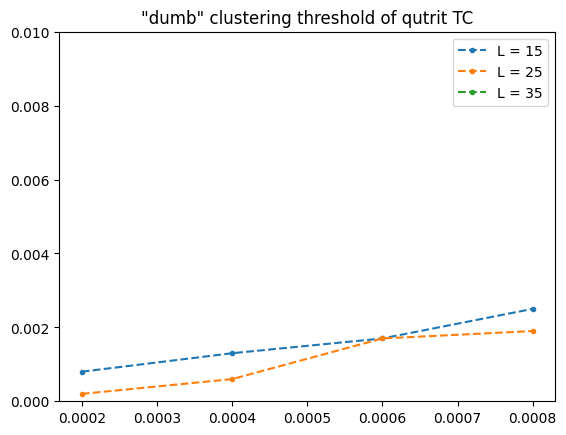

In [117]:
for L in N_list:
    plt.plot(p_list[:4],threshhold_dict[L][:4], '.--', label = f'L = {L}')
    plt.ylim(0,.01)

plt.title('"dumb" clustering threshold of qutrit TC')
plt.legend()

In [115]:
threshhold_dict

{15: [0.0008000000000000229,
  0.0012999999999999678,
  0.0017000000000000348,
  0.0024999999999999467,
  0.0029000000000000137],
 25: [0.00019999999999997797,
  0.0006000000000000449,
  0.0017000000000000348,
  0.0019000000000000128,
  0.0040000000000000036],
 35: [0.10540000000000005,
  0.20009999999999994,
  0.26839999999999997,
  0.33699999999999997,
  0.4154]}